In [1]:
from data import colorize_image as CI
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# load images
imgs2read = open('imgs2read.txt', 'r')
allimgs2read = []
for line in imgs2read:
    line = line.strip()
    line = line.split()
    for img in line:
        if '-targets' in img:
            img = img.replace('-targets.png', '')
            allimgs2read.append(img)

# Choose gpu to run the model on
gpu_id = 0

# Initialize colorization class
colorModel = CI.ColorizeImageCaffe(Xd=256)

# Load the model
colorModel.prep_net(gpu_id,'./models/reference_model/deploy_nodist.prototxt','./models/reference_model/model.caffemodel')


ColorizeImageCaffe instantiated
gpu_id = 0, net_path = ./models/reference_model/deploy_nodist.prototxt, model_path = ./models/reference_model/model.caffemodel


photo-1481068164146-e8beb686f4d2
photo-1491759683820-492a6de5504c
dcc2ccd9
photo-1498842812179-c81beecf902c
photo-1481077147437-4b5f9bb774df
photo-1491818689676-f257892134ef
photo-1415769663272-8504c6cc02b3
photo-1499167998325-c2980f5cb329
photo-1481141726884-014a1f27d993
photo-1491864402166-274ee7bfc5f7


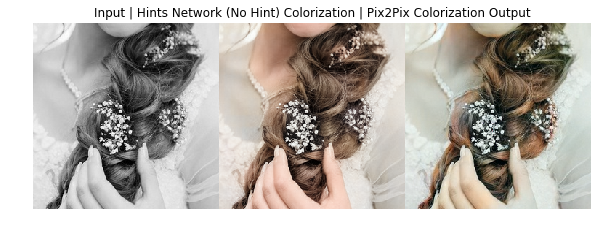

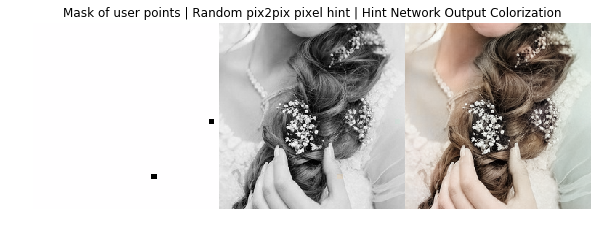

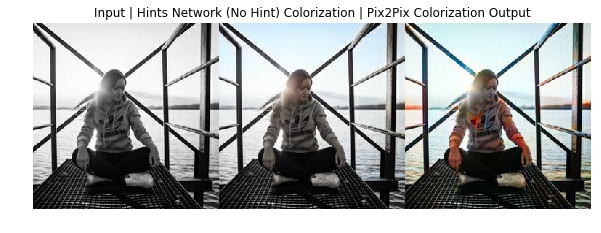

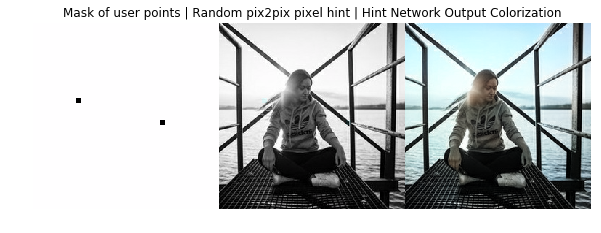

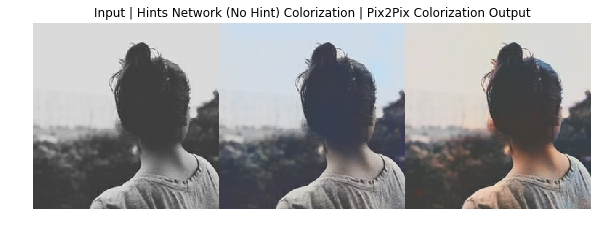

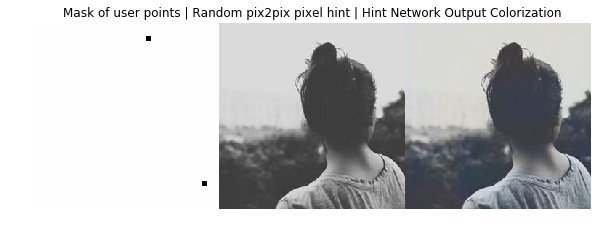

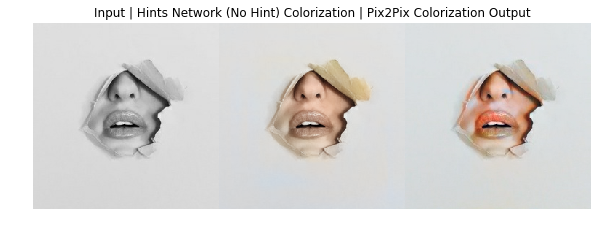

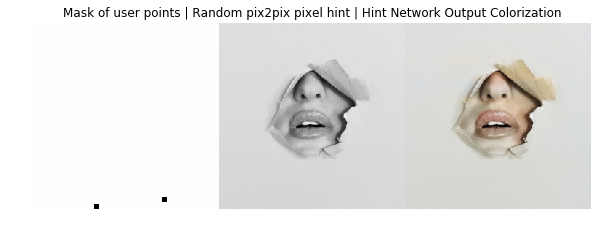

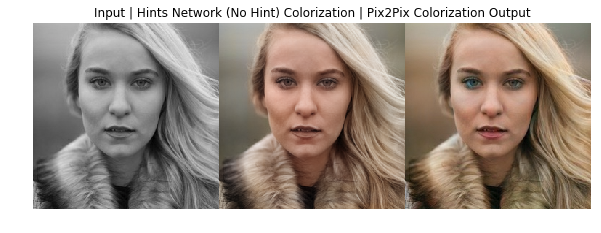

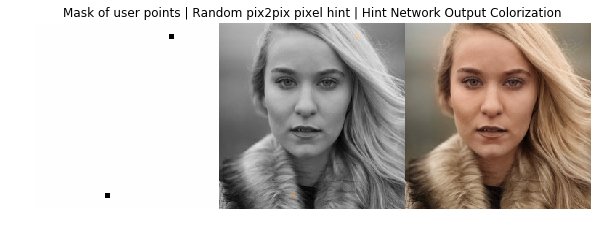

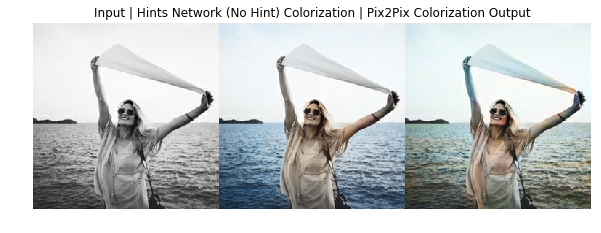

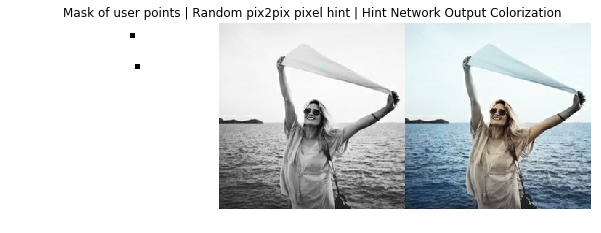

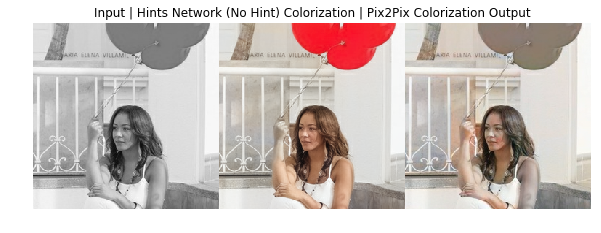

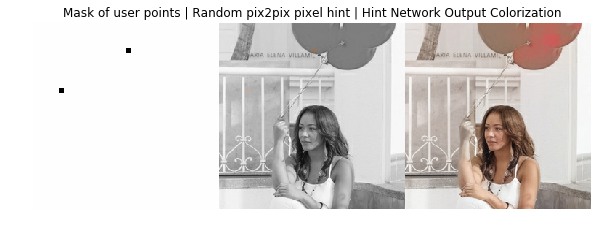

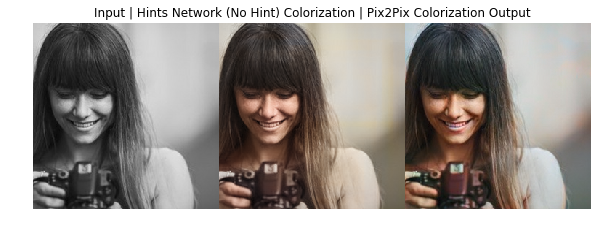

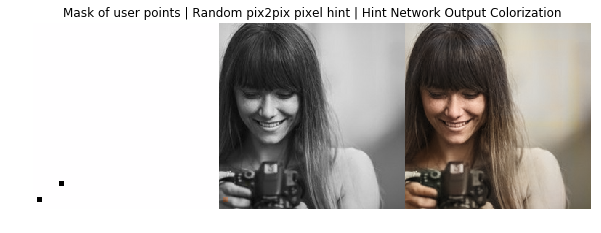

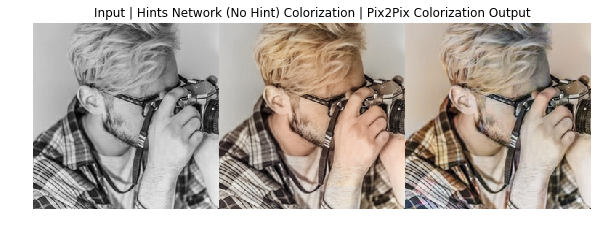

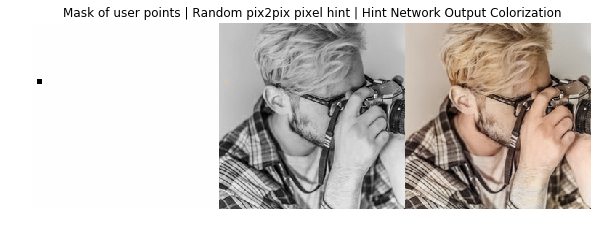

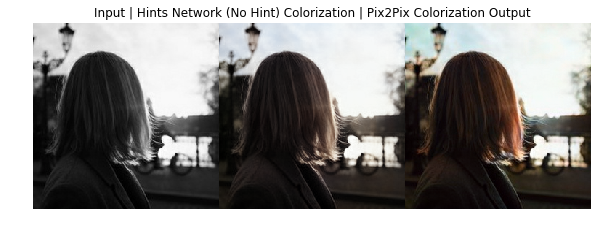

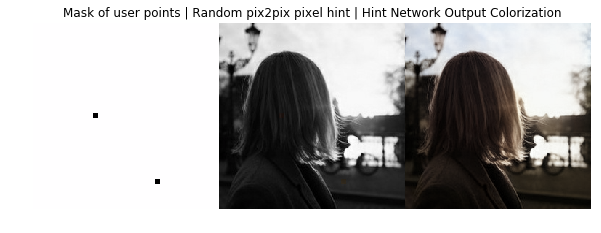

In [5]:
import matplotlib.image as mpimg
from PIL import Image

count = 0

for img in allimgs2read:
    print(img)
    # Load the image
    img_type = '-targets.png'
    img_url = './images/' + img
    pix2pix_output = Image.open(img_url + '-outputs.png')
    colorModel.load_image(img_url+'-targets.png') # load an image

    mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
    input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
    img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

    img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution


    
    # show result
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres, pix2pix_output),axis=1)); plt.axis('off');
    plt.title('Input | Hints Network (No Hint) Colorization | Pix2Pix Colorization Output')
    def put_point(input_ab,mask,loc,p,val):
        # input_ab    2x256x256    current user ab input (will be updated)
        # mask        1x256x256    binary mask of current user input (will be updated)
        # loc         2 tuple      (h,w) of where to put the user input
        # p           scalar       half-patch size
        # val         2 tuple      (a,b) value of user input
        input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
        mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
        return (input_ab,mask)

    # get random pixel hint from colored output of pix2pix
    from skimage import io, color
    import random
    rgb = io.imread(img_url+'-outputs.png')
    lab = color.rgb2lab(rgb)
    x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
    random_pix2pix_output_loc = [x,y]
    random_pix2pix_output_hint = list(lab[x][y])[1:]
    x,y = random.randint(0,len(lab)-1), random.randint(0,len(lab[0])-1)
    random_pix2pix_output_loc2 = [x,y]
    random_pix2pix_output_hint2 = list(lab[x][y])[1:]
    #print(random_pix2pix_output_loc,random_pix2pix_output_hint)

    # initialize with no user inputs
    input_ab = np.zeros((2,256,256))
    mask = np.zeros((1,256,256))

    # add a random point to the image
    (input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc,3,random_pix2pix_output_hint)
    (input_ab,mask) = put_point(input_ab,mask,random_pix2pix_output_loc2,3,random_pix2pix_output_hint2)

    # call forward
    img_out = colorModel.net_forward(input_ab,mask)

    # get mask, input image, and result in full resolution
    mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
    img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

    # show user input, along with output
    plt.figure(figsize=(10,6))
    plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
    plt.title('Mask of user points | Random pix2pix pixel hint | Hint Network Output Colorization')
    plt.axis('off');
    count +=1
    if count == 10:
        break
plt.show()